# Portfolio Optimization: Monte Carlo Simulation & Constraints-based Optimization

Portfolio optimization is the process of selecting an optimal portfolio (asset distribution), out of a set of considered portfolios, according to some objective. The objective typically maximizes factors such as expected return, and minimizes costs like financial risk, resulting in a multi-objective optimization problem.

The objective of this project is to optimize an all-equity portfolio using past 6 months of OHLC data. For this purpose, I've used my own active portfolio and optimized it using two approaches: Monte Carlo Simulation & Constraints-based optimization.

We will perform Monte Carlo Simulation using a manual function and will utilise scipy.optimize package to perform optimization using constraints.





In [28]:
# import packages
import pathlib
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.optimize as sci_plt
import datetime as dt
from pprint import pprint
from sklearn.preprocessing import StandardScaler

# set pandas display options
pd.set_option("display.max_colwidth", None)
pd.set_option("expand_frame_repr", False)

# set random_seed for reproducibility
np.random.seed(42)

# **Data Gathering & Pre-processing**

First step is to import and accumulate OHLC data for the past 6 months for the portfolio of equities. My portfolio consists of SUZLON, ZOMATO, MOTHERSON and I will use Yahoo! Finance to pull the required data.

In [29]:
# get historical OHLC data for the portfolio of stocks

portfolio = ["SUZLON.NS", "ZOMATO.NS", "MOTHERSON.NS"] # edit this as per desire

def get_history(portfolio=portfolio):

  # create empty list to hold OHLC data for the portfolio
  ohlc = []

  for ticker in portfolio:
    stock = yf.Ticker(ticker)

    # get past 6 months worth data
    history = stock.history(period="6mo")

    # add a new column "symbol" to denote the parent of each data point
    history["symbol"] = ticker

    # add to the list
    ohlc.append(history)

  # create a pandas dataframe for history
  history_df = pd.concat(ohlc, axis=0)

  # reset index to switch "Date" from index to column
  history_df.reset_index(inplace=True)

  # return final dataset
  return history_df

In [30]:
data = get_history()
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,symbol
0,2024-05-06 00:00:00+05:30,42.000000,42.000000,40.400002,40.799999,17232143,0.0,0.0,SUZLON.NS
1,2024-05-07 00:00:00+05:30,40.750000,40.799999,39.000000,39.750000,27831110,0.0,0.0,SUZLON.NS
2,2024-05-08 00:00:00+05:30,39.750000,40.200001,39.049999,39.950001,24940794,0.0,0.0,SUZLON.NS
3,2024-05-09 00:00:00+05:30,40.000000,40.400002,39.450001,39.599998,21071854,0.0,0.0,SUZLON.NS
4,2024-05-10 00:00:00+05:30,39.849998,40.099998,39.000000,39.900002,14667345,0.0,0.0,SUZLON.NS


In [31]:
data.symbol.value_counts()

,count
symbol,
SUZLON.NS,128
ZOMATO.NS,128
MOTHERSON.NS,128


In [32]:
# need to clean format for the "Date" column

data["Date"] = pd.to_datetime(data["Date"]) # set the data type as datetime object
data["Date"] = data["Date"].dt.date # convert to only date
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,symbol
0,2024-05-06,42.000000,42.000000,40.400002,40.799999,17232143,0.0,0.0,SUZLON.NS
1,2024-05-07,40.750000,40.799999,39.000000,39.750000,27831110,0.0,0.0,SUZLON.NS
2,2024-05-08,39.750000,40.200001,39.049999,39.950001,24940794,0.0,0.0,SUZLON.NS
3,2024-05-09,40.000000,40.400002,39.450001,39.599998,21071854,0.0,0.0,SUZLON.NS
4,2024-05-10,39.849998,40.099998,39.000000,39.900002,14667345,0.0,0.0,SUZLON.NS


This data is pretty close to what we need, but we will have to modify this data to be able to calculate daily log returns which are an essential ingredient to calculate the metrics we will use to judge a portfolio - Sharpe Ratio, Expected Return, Risk/Volatility (Standard Deviation).

We will transform this data in a way such that for every symbol we have a vertically-stacked dataframe in ascending order. We do this in the next step.

## Re-organsing Data

In [33]:
# reorganising data

price_data = data.pivot(
    index="Date",
    columns="symbol",
    values="Close"
)
price_data

symbol,MOTHERSON.NS,SUZLON.NS,ZOMATO.NS
Date,,,
2024-05-06,127.283974,40.799999,195.699997
2024-05-07,124.844826,39.750000,191.449997
2024-05-08,128.179993,39.950001,195.449997
2024-05-09,124.944382,39.599998,195.250000
2024-05-10,127.035080,39.900002,201.300003
...,...,...,...
2024-10-31,180.949997,66.949997,241.750000
2024-11-01,180.949997,68.139999,241.750000
2024-11-04,185.110001,66.320000,245.080002


In [34]:
price_data.isnull().value_counts() # checking if close price is missing for a stock for any date

,,,count
MOTHERSON.NS,SUZLON.NS,ZOMATO.NS,
False,False,False,128


This data is now ready to be used for optimization purposes. In the next section, we will optimize this portfolio using Monte Carlo simulation & constrains-based optimization approach.

# **Optimization**

We start off with Monte Carlo simulation. To perform any kind of optimization we first need a base portfolio ***to optimize***, we will use a randomly-allocated portfolio for this purpose.

In [35]:
# generate random weights for portfolio
random_weights = np.array(np.random.random(len(portfolio))) # generate N number of weights, where N = no. of stocks in portfolio
display(random_weights)

array([0.37454012, 0.95071431, 0.73199394])

Notice that the total weight of the portfolio exceeds 1 which is obviously not possible. We need to rebalance the weights or in other words **normalize** the weights such that the total weight of the portfolio is always 1.

In [36]:
def get_weights(portfolio):

  '''
  Generate random weights and convert to normalized weights for a portfolio

  Input:
    1. portfolio --> list of stocks in the portfolio

  Output:
    1. rebalanced_random_weights --> normalized weights assigned to each stock in a portfolio

  '''
  # generate random weights for portfolio
  random_weights = np.array(np.random.random(len(portfolio))) # generate N number of weights, where N = no. of stocks in portfolio

  # normalize the weights to restrict the total to 1
  rebalanced_random_weights = random_weights / np.sum(random_weights) # normalize the weights
  rebalanced_random_weights = np.round(rebalanced_random_weights, 2) # round to 2 decimal places

  # return the rebalanced weights
  return rebalanced_random_weights


In [54]:
portfolio_weights = get_weights(portfolio)
portfolio_weights

array([0.57, 0.01, 0.42])

Once we have the normalized weights of the portfolio, we will create a function which returns metrics for a portfolio. These metrics will be used to judge the health and performance of the portfolio, specifically we are interested in the Sharpe Ratio, Expected Return & Volatility or Risk of the portfolio.

The base portfolio assigned 57% weight to MOTHERSON, 1% to SUZLON, and 42% to ZOMATO.

We will use log returns for our analysis as they have various advantages over arithmetic returns expecially in financial quantitative analysis which mostly utilises time-series data. Think about this:

The arithmetic return is calculated as:

$$
    Arithmetic Return = \frac{End Price − Start Price}{Start Price}
     = 110 − 100/100 = 0.10 = 10\%
$$


The log return is calculated using the natural logarithm of the price ratio:


$$
    Log Return = ln(\frac{End Price}{Start Price}) = ln(\frac{110}{100}) ≈ ln(1.1) = 0.0953 =  9.53\%
$$

As we can see, while both returns are similar, the log return slightly underestimates compared to the arithmetic return. However, if we have multiple periods, log returns allow us to add them up directly to calculate the total return, while arithmetic returns would require compounding. This property of log returns is particularly useful in projects where we analyze returns over multiple time periods.

In [38]:
# calculate annualized expected return for random-weighted portfolio
# and expected annualized volatility (risk) for random-weighted portfolio
# and sharpe ratio

def get_metrics(normalized_weights, price_data):

  '''
  Calculate risk, return & performance metrics for a portfolio.

  Input:
    1. weights --> normalized weights assigned to each stock in a portfolio
    2. price_data --> close price data for portfolio of stocks, stacked vertically in ascending order by date

  Output:
    1. expected_return --> annualized expected return for the portfolio
    2. expected_volatility --> annualized expected volatility (risk) for the portfolio
    3. sharpe_ratio --> annualized sharpe ratio for the portfolio
    4. negative_sharpe_ratio --> negative sharpe ratio for the portfolio
    5. log_returns --> log returns for the portfolio

  '''

  # calculate log expected returns
  log_returns = np.log(1 + price_data.pct_change())

  # calculate annualized expected return for random-weighted portfolio
  expected_return = np.sum((normalized_weights * log_returns.mean() * 252))

  # calculate expected annualized volatility (risk) for the random-weighted portfolio
  expected_volatility = np.sqrt(
      np.dot(
          normalized_weights.T,
          np.dot(
              log_returns.cov() * 252,
              normalized_weights
          )
      )
  )

  # calculate annualized sharpe ratio for portfolio
  sharpe_ratio = expected_return / expected_volatility # we can subtract the risk-free rate from the expected return to get a more definite picture, it is not used here for simplicity

  # calculate negative sharpe, to use while minimizing the scipy.optimize function
  # as it does not have a maximization function
  negative_sharpe_ratio = -1 * sharpe_ratio

  # return the metrics
  return expected_return, expected_volatility, sharpe_ratio, negative_sharpe_ratio, log_returns


We calculate negative sharpe ratio because scipy.optimize doesn't have a "maximize" function, only a "minimize" function. The thought is to convert sharpe to negative sharpe and perform minimization to be able to get the lowest negative sharpe which will be the highest positive sharpe in the original form.

In [39]:
metrics = get_metrics(get_weights(portfolio), price_data)

# print metrics
print('')
print('='*80)
print('PORTFOLIO METRICS')
print('-'*80)
print("Expected Return of Portfolio:  ", round(metrics[0] * 100, 2))
print("Expected Volatility of Portfolio: ", round(metrics[1] * 100, 2))
print("Sharpe Ratio of Portfolio: ", round(metrics[2], 2))
print('='*80)


PORTFOLIO METRICS
--------------------------------------------------------------------------------
Expected Return of Portfolio:   77.72
Expected Volatility of Portfolio:  29.28
Sharpe Ratio of Portfolio:  2.65


With random allocation, we achieve a sharpe ratio of 2.65, expected return of 77.72% with the expected volatility being 29.28%. We will now try to optimize this portfolio using Monte Carlo simulation.

## Monte Carlo Simulation


We will run a 1000 simulations which in others words are 1000 possibilities of the future. The intention is to randomly allocate weights or create a portfolio "enough" times that it gives us an optimal portfolio eventually, based on the desired metric.

In [40]:

# no. of simulations to run
num_simulations = 1000

# zero matrix for weights
weights_matrix = np.zeros((len(portfolio), num_simulations))

# zero vector for expected returns
returns_vector = np.zeros(num_simulations)

# zero vector for expected volatility
volatility_vector = np.zeros(num_simulations)

# zero vector for sharpe ratios
sharpe_ratios_vector = np.zeros(num_simulations)

# start simulation
for i in range(num_simulations):

  # get random weights
  mc_random_weights = get_weights(portfolio)

  # get risk, return & performance metrics
  mc_expected_return, mc_expected_volatility, mc_sharpe_ratio = get_metrics(mc_random_weights, price_data)[:3]

  # add to respective matrice and vectors
  weights_matrix[:, i] = mc_random_weights
  returns_vector[i] = mc_expected_return
  volatility_vector[i] = mc_expected_volatility
  sharpe_ratios_vector[i] = mc_sharpe_ratio

# combine simulation data together
simulation_data = pd.DataFrame({
    "Expected Return": returns_vector,
    "Expected Volatility": volatility_vector,
    "Sharpe Ratio": sharpe_ratios_vector,
    'Weights': list(weights_matrix.T)
})

# print simulations
print('')
print('='*80)
print('SIMULATIONS')
print('-'*80)
print(simulation_data.head())
print('='*80)




SIMULATIONS
--------------------------------------------------------------------------------
   Expected Return  Expected Volatility  Sharpe Ratio             Weights
0         0.835003             0.330764      2.524465  [0.04, 0.57, 0.39]
1         0.633630             0.306902      2.064601  [0.42, 0.01, 0.57]
2         0.782108             0.295423      2.647418  [0.68, 0.17, 0.15]
3         0.727249             0.298922      2.432909   [0.18, 0.3, 0.52]
4         0.719631             0.285806      2.517899  [0.32, 0.22, 0.46]


After the simulation is completed, we will pull 3 portfolio - max. sharpe, max. return, and min. risk. This should help target various investor personas and give a picture of how an investor can allocate resources based on their risk profile and aggressiveness.

In [41]:
# simulation that gave us the max Sharpe ratio
max_sharpe = simulation_data.iloc[simulation_data['Sharpe Ratio'].idxmax()]

# print portfolio
print('')
print('='*80)
print('MAX SHARPE PORTFOLIO')
print('-'*80)
print(max_sharpe)
print('='*80)


MAX SHARPE PORTFOLIO
--------------------------------------------------------------------------------
Expected Return                  0.880663
Expected Volatility              0.298878
Sharpe Ratio                     2.946562
Weights                [0.46, 0.46, 0.08]
Name: 597, dtype: object


In [42]:
# simulation with highest expected return
max_return = simulation_data.iloc[simulation_data['Expected Return'].idxmax()]

# print portfolio
print('')
print('='*80)
print('MAX RETURN PORTFOLIO')
print('-'*80)
print(max_return)
print('='*80)


MAX RETURN PORTFOLIO
--------------------------------------------------------------------------------
Expected Return                  1.032806
Expected Volatility              0.420274
Sharpe Ratio                     2.457462
Weights                [0.03, 0.95, 0.02]
Name: 347, dtype: object


In [43]:
# simulation with lowest volatility
min_vol = simulation_data.iloc[simulation_data['Expected Volatility'].idxmin()]

# print portfolio
print('')
print('='*80)
print('MIN VOLATILITY PORTFOLIO')
print('-'*80)
print(min_vol)
print('='*80)



MIN VOLATILITY PORTFOLIO
--------------------------------------------------------------------------------
Expected Return                   0.76014
Expected Volatility               0.27591
Sharpe Ratio                     2.755032
Weights                [0.42, 0.26, 0.31]
Name: 545, dtype: object


For an aggressive investor, portfolio with max. return should be the suitable option as it it very high-risk with a volatility of 42% but gives out an expected return of 102%. For a conservative investor, a min. risk portfolio with annualized 26% volatility and an expected return of 76% should be the right choice.

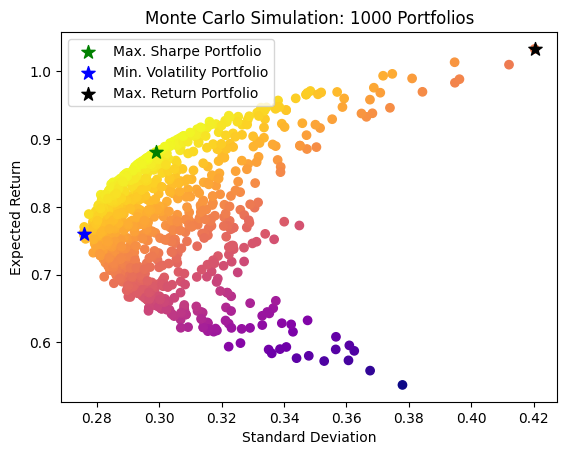

In [44]:
# create figure and axis
fig, ax = plt.subplots()

# plot expected return vs expected volatility
ax.scatter(
    simulation_data["Expected Volatility"],
    simulation_data["Expected Return"],
    c=simulation_data["Sharpe Ratio"],
    cmap="plasma"
)

# plot max sharpe portfolio
green = ax.scatter(
    max_sharpe["Expected Volatility"],
    max_sharpe["Expected Return"],
    c="green",
    marker="*",
    s=100,
    label="Max. Sharpe Portfolio"
)

# plot min volatility portfolio
blue = ax.scatter(
    min_vol["Expected Volatility"],
    min_vol["Expected Return"],
    c="blue",
    marker="*",
    s=100,
    label="Min. Volatility Portfolio"
)

# plit max return portfolio
black = ax.scatter(
    max_return["Expected Volatility"],
    max_return["Expected Return"],
    c="black",
    marker="*",
    s=100,
    label="Max. Return Portfolio"
)

ax.legend(handles=[green, blue, black])
plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")
plt.title("Monte Carlo Simulation: 1000 Portfolios")
plt.show()

In the chart above we plot the sharpe ratio of every one of the 1000 portfolio of simulations generated by the algorithm. We have also marked the three portfolios we pulled from the data targeting various investor groups.

## Constraints-based Optimization

In this second approach, we will optimize our portfolio based on a constraint that we want to dictate on the portfolio, for e.g. the level of risk, % of portfolio allocation, minimum return, etc. For the sake of simplicity, we will constraint our portfolio to 100% allocation and optimize for maximum sharpe.

As seen above, based on a trader's risk profile this optimization can be modified to suit their needs but sharpe ratio is usually the best and safe estimate to judge performance as it incorporate risk into the mix while judging performance along with risk-free rate (which is assumed to be 0% for this analysis).

For this approach, I've used the original allocation of my active portfolio as the base portfolio before we perform optimization.



In [45]:

# optimizing for maximum sharpe

# ensure full allocation of portfolio
def constraint_func(weights):
    return np.sum(weights) - 1

# define bounds
bounds = tuple((0, 1) for x in range(len(portfolio)))

# define constraints
constraints = ({'type': 'eq', 'fun': constraint_func})

# initial guess of portfolio allocation
init_guess = [0.23, 0.32, 0.45]

# optimize weights
optimized_sharpe = sci_plt.minimize(
    fun=lambda x: get_metrics(x, price_data)[3],
    x0=init_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# ensure full allocation of portfolio
def constraint_func(weights):
    return np.sum(weights) - 1

# define bounds
bounds = tuple((0, 1) for x in range(len(portfolio))) # dictates 100% boundary for each stock - allocation for a stock has to be between 0 and 100

# define constraints
constraints = ({'type': 'eq', 'fun': constraint_func})

# initial guess of portfolio allocation
init_guess = [0.23, 0.32, 0.45]

# optimize weights
optimized_metric = sci_plt.minimize(
    fun=lambda x: get_metrics(x, price_data)[1],
    x0=init_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

In [46]:
optimized_sharpe_results = get_metrics(optimized_sharpe.x, price_data)

In [47]:
# grab results
optimized_sharpe_results = get_metrics(optimized_sharpe.x, price_data)

# print metrics
print('')
print('='*80)
print('PORTFOLIO METRICS')
print('-'*80)
print("Expected Return of Portfolio:  ", round(optimized_sharpe_results[0] * 100, 2))
print("Expected Volatility of Portfolio: ", round(optimized_sharpe_results[1] * 100, 2))
print("Sharpe Ratio of Portfolio: ", round(optimized_sharpe_results[2], 2))
print("Optimized Weights: ", optimized_sharpe.x)
print('='*80)


PORTFOLIO METRICS
--------------------------------------------------------------------------------
Expected Return of Portfolio:   87.8
Expected Volatility of Portfolio:  29.8
Sharpe Ratio of Portfolio:  2.95
Optimized Weights:  [0.45881159 0.45554286 0.08564555]


This portfolio is almost exactly the same as the monte carlo simulation's Max. Sharpe portfolio which only adds more confidence to this portfolio. In terms of performance, this portfolio gives a return of 88% annualized with a a volatility of 30% and a sharpe of 2.95. The allocation is also relatively balanced with 46% in MOTHERSON, 46% in SUZLON, and 8% in ZOMATO.

## Potential Improvements

1. We can try to optimize it for a different metric - volatility - to minimize the risk incurred by an investor
2. We can add more constraints to the algorithm, such as max. risk, min. return, max. allocation per stock, which should help personalize the portfolio for a particular scenario.